In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sqlalchemy import create_engine
from scipy.stats import boxcox, jarque_bera, normaltest
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import scale, normalize, StandardScaler
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'
table_name = 'lifeexpectancy'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

life = pd.read_sql_query('SELECT * FROM {}'.format(table_name), con= engine)

engine.dispose()

In [3]:
life.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [4]:
len(life.columns)

22

In [5]:
len(life['Status'].unique())

2

### Detect the problems with the data such as missing values and outliers. Are there any nonsense values that seem to be stemmed from the data collection? For the missing values, discuss which technique would be the most suitable one in filling out these values. Regarding the outliers, discuss their potential effects on your analysis and select an appropriate method to deal with them.

In [6]:
# percentage of nulls per column
(life.isnull().sum() * 100) / len(life)

Country                             0.000000
Year                                0.000000
Status                              0.000000
Life expectancy                     0.340368
Adult Mortality                     0.340368
infant deaths                       0.000000
Alcohol                             6.603131
percentage expenditure              0.000000
Hepatitis B                        18.822328
Measles                             0.000000
 BMI                                1.157250
under-five deaths                   0.000000
Polio                               0.646698
Total expenditure                   7.692308
Diphtheria                          0.646698
 HIV/AIDS                           0.000000
GDP                                15.248468
Population                         22.191967
 thinness  1-19 years               1.157250
 thinness 5-9 years                 1.157250
Income composition of resources     5.684139
Schooling                           5.547992
dtype: flo

In [7]:
life.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10   BMI                             2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

In [8]:
life.describe(include = 'all')

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,2938,2938.000000,2938,2928.000000,2928.000000,2938.000000,2744.000000,2938.000000,2385.000000,2938.000000,...,2919.000000,2712.00000,2919.000000,2938.000000,2490.000000,2.286000e+03,2904.000000,2904.000000,2771.000000,2775.000000
unique,193,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Malta,NaN,Developing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,16,NaN,2426,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2007.518720,NaN,69.224932,164.796448,30.303948,4.602861,738.251295,80.940461,2419.592240,...,82.550188,5.93819,82.324084,1.742103,7483.158469,1.275338e+07,4.839704,4.870317,0.627551,11.992793
std,NaN,4.613841,NaN,9.523867,124.292079,117.926501,4.052413,1987.914858,25.070016,11467.272489,...,23.428046,2.49832,23.716912,5.077785,14270.169342,6.101210e+07,4.420195,4.508882,0.210904,3.358920
min,NaN,2000.000000,NaN,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,...,3.000000,0.37000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,NaN,2004.000000,NaN,63.100000,74.000000,0.000000,0.877500,4.685343,77.000000,0.000000,...,78.000000,4.26000,78.000000,0.100000,463.935626,1.957932e+05,1.600000,1.500000,0.493000,10.100000
50%,NaN,2008.000000,NaN,72.100000,144.000000,3.000000,3.755000,64.912906,92.000000,17.000000,...,93.000000,5.75500,93.000000,0.100000,1766.947595,1.386542e+06,3.300000,3.300000,0.677000,12.300000
75%,NaN,2012.000000,NaN,75.700000,228.000000,22.000000,7.702500,441.534144,97.000000,360.250000,...,97.000000,7.49250,97.000000,0.800000,5910.806335,7.420359e+06,7.200000,7.200000,0.779000,14.300000


In [9]:
# make dataframe where all nulls are interpolated
no_nulls = life.copy()
for col in no_nulls.columns:
    no_nulls.loc[:, col] = no_nulls[col].interpolate(limit_direction='both')

In [10]:
numeric_cols = no_nulls.columns[3:]
print(numeric_cols)

Index(['Life expectancy ', 'Adult Mortality', 'infant deaths', 'Alcohol',
       'percentage expenditure', 'Hepatitis B', 'Measles ', ' BMI ',
       'under-five deaths ', 'Polio', 'Total expenditure', 'Diphtheria ',
       ' HIV/AIDS', 'GDP', 'Population', ' thinness  1-19 years',
       ' thinness 5-9 years', 'Income composition of resources', 'Schooling'],
      dtype='object')


In [11]:
# Interquartile Range method for determining outliers

threshold = 1.5

for col in numeric_cols:
    qR90, qR10 = np.percentile(no_nulls[col], [90 ,10])
    iqr_R = qR90 - qR10
    min_val_R = qR10 - (iqr_R*threshold)
    max_val_R = qR90 + (iqr_R*threshold)
    outliers = len(np.where((no_nulls[col] > max_val_R) | (no_nulls[col] < min_val_R))[0])
    print("outliers for {} is: {}".format(col, outliers))
    
    if outliers > 0:
        winsorized = winsorize(no_nulls[col], (0.1, 0.1))
        no_nulls.loc[:, col] = winsorized
        outliers = len(np.where((no_nulls[col] > max_val_R) | (no_nulls[col] < min_val_R))[0])
        print('outliers after winsorize: {}'.format(outliers))
    print('\n')

outliers for Life expectancy  is: 0


outliers for Adult Mortality is: 0


outliers for infant deaths is: 110
outliers after winsorize: 0


outliers for Alcohol is: 0


outliers for percentage expenditure is: 142
outliers after winsorize: 0


outliers for Hepatitis B is: 0


outliers for Measles  is: 162
outliers after winsorize: 0


outliers for  BMI  is: 0


outliers for under-five deaths  is: 100
outliers after winsorize: 0


outliers for Polio is: 0


outliers for Total expenditure is: 0


outliers for Diphtheria  is: 0


outliers for  HIV/AIDS is: 116
outliers after winsorize: 0


outliers for GDP is: 51
outliers after winsorize: 0


outliers for Population is: 97
outliers after winsorize: 0


outliers for  thinness  1-19 years is: 16
outliers after winsorize: 0


outliers for  thinness 5-9 years is: 16
outliers after winsorize: 0


outliers for Income composition of resources is: 0


outliers for Schooling is: 0




### Explore the data using univariate and multivariate exploration techniques. You should pay special attention to your target variable. In this regard, your focus should be on finding the relevant variables that may affect life expectancy.

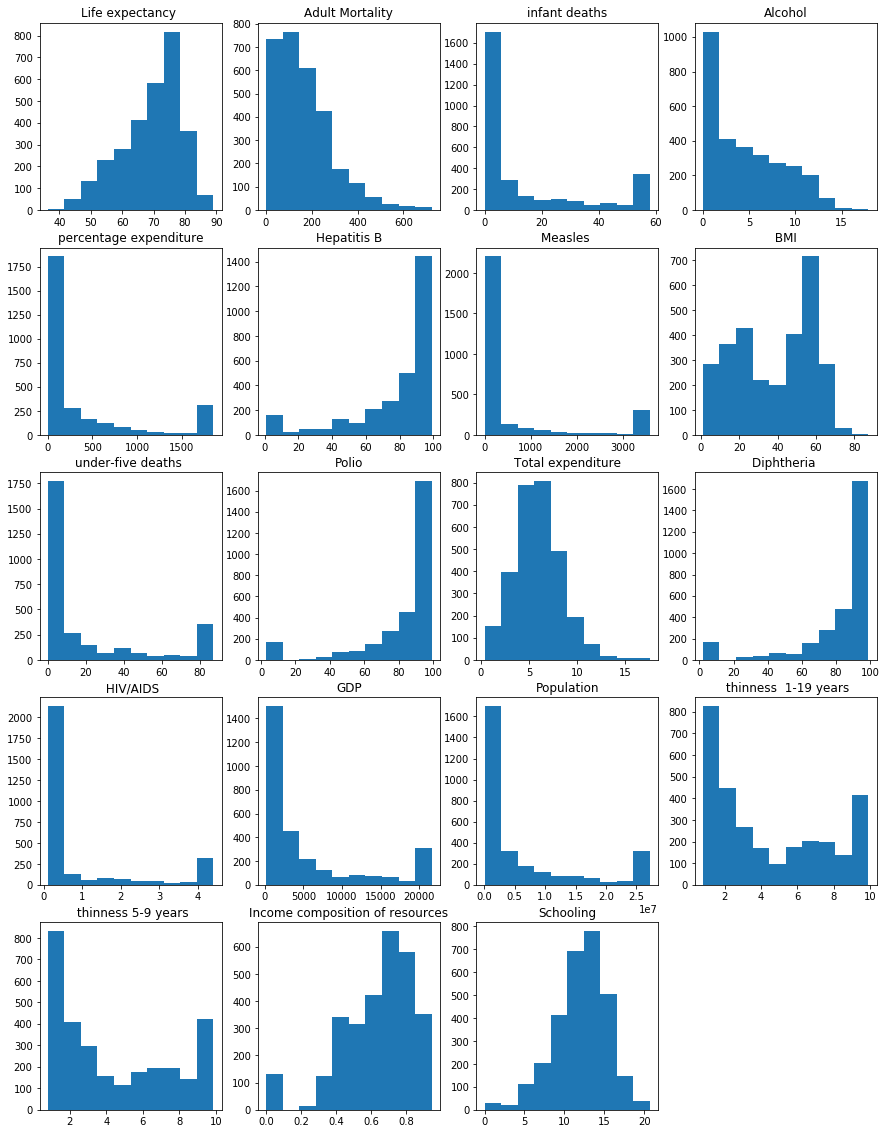

In [12]:
# Univariate analysis with histograms
fig = plt.subplots(figsize=(15,20))
for x in range(len(numeric_cols)):
    plt.subplot(5, 4, x+1)
    plt.hist(no_nulls.iloc[:, x+3])
    plt.title('{}'.format(numeric_cols[x]))

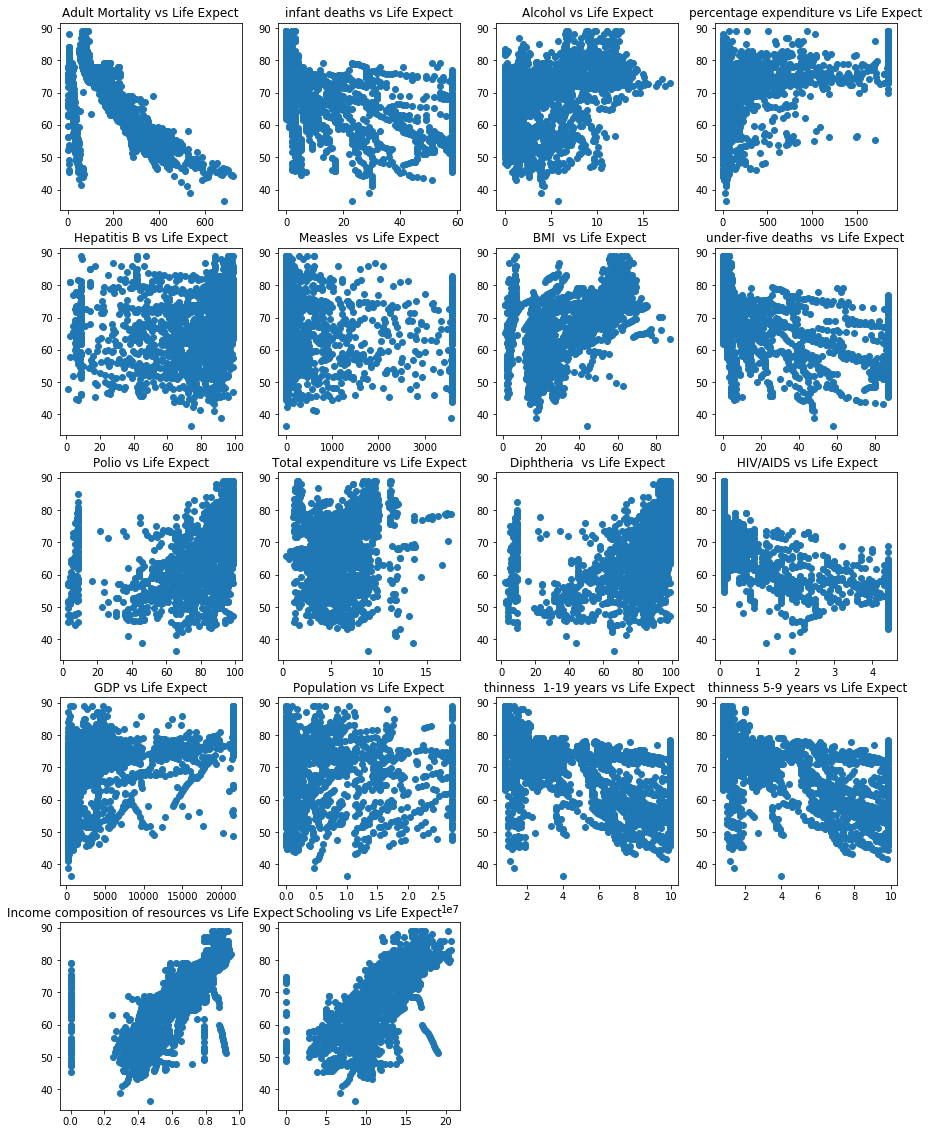

In [13]:
# multivariate analysis with scatter plots
fig = plt.subplots(figsize=(15,20))
for x in range(1, len(numeric_cols)):
    plt.subplot(5, 4, x)
    plt.scatter(no_nulls.iloc[:, x+3], no_nulls[numeric_cols[0]])
    plt.title('{} vs Life Expect'.format(numeric_cols[x]))

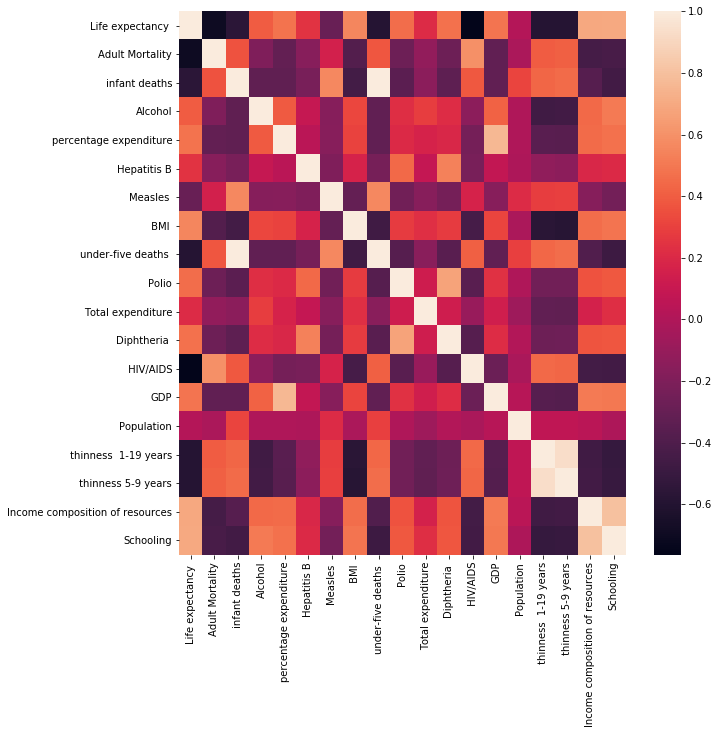

In [14]:
# correlation heatmap
plt.figure(figsize=(10,10))
num_corr = no_nulls[numeric_cols].corr()
sns.heatmap(num_corr)

In [15]:
# look at exact correlation values
num_corr

,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
Life expectancy,1.000000,-0.695730,-0.560574,0.400068,0.482369,0.247419,-0.292792,0.556433,-0.588655,0.459865,0.210843,0.474084,-0.763313,0.487721,0.021360,-0.589282,-0.590142,0.690071,0.703409
Adult Mortality,-0.695730,1.000000,0.361392,-0.194070,-0.311380,-0.162578,0.155390,-0.383224,0.378708,-0.272553,-0.116293,-0.273311,0.599689,-0.315945,-0.017052,0.400410,0.409646,-0.440536,-0.430481
infant deaths,-0.560574,0.361392,1.000000,-0.325668,-0.323234,-0.222556,0.561331,-0.447790,0.993803,-0.346628,-0.148757,-0.331013,0.383160,-0.321669,0.315710,0.429293,0.450751,-0.366754,-0.460089
Alcohol,0.400068,-0.194070,-0.325668,1.000000,0.392668,0.092366,-0.168498,0.319618,-0.321516,0.222830,0.289631,0.218683,-0.137008,0.415392,-0.004719,-0.464703,-0.454652,0.442169,0.507064
percentage expenditure,0.482369,-0.311380,-0.323234,0.392668,1.000000,0.042649,-0.157610,0.309963,-0.319952,0.205264,0.167119,0.192680,-0.239000,0.765202,-0.003967,-0.354734,-0.360650,0.453115,0.470601
Hepatitis B,0.247419,-0.162578,-0.222556,0.092366,0.042649,1.000000,-0.194837,0.172639,-0.232254,0.446056,0.088999,0.532925,-0.221235,0.081743,-0.006187,-0.128989,-0.138468,0.193478,0.201451
Measles,-0.292792,0.155390,0.561331,-0.168498,-0.157610,-0.194837,1.000000,-0.303091,0.563575,-0.249315,-0.160566,-0.234994,0.167632,-0.160108,0.212152,0.284429,0.293547,-0.164998,-0.242288
BMI,0.556433,-0.383224,-0.447790,0.319618,0.309963,0.172639,-0.303091,1.000000,-0.466468,0.282080,0.233848,0.280483,-0.435648,0.316827,-0.019145,-0.569095,-0.579698,0.461457,0.488210
under-five deaths,-0.588655,0.378708,0.993803,-0.321516,-0.319952,-0.232254,0.563575,-0.466468,1.000000,-0.364335,-0.151356,-0.350797,0.412333,-0.321477,0.296629,0.438171,0.456043,-0.387224,-0.478703
Polio,0.459865,-0.272553,-0.346628,0.222830,0.205264,0.446056,-0.249315,0.282080,-0.364335,1.000000,0.130634,0.675339,-0.353293,0.236547,0.000565,-0.251846,-0.252949,0.360154,0.382657


'Schooling' and 'Income composition of resources' had the strongest positive correlation to 'Life expectancy'

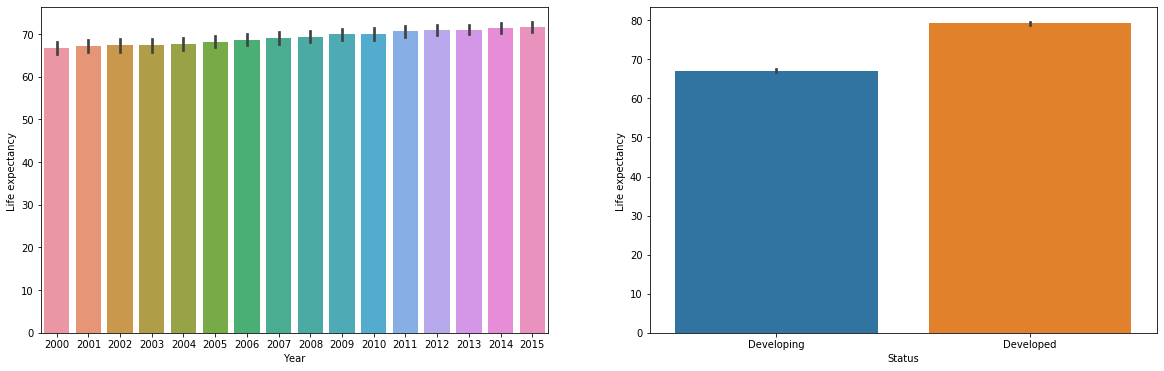

In [16]:
plt.figure(figsize=(20,6))
plt.subplot(1, 2, 1)
sns.barplot(no_nulls['Year'], no_nulls[numeric_cols[0]])

plt.subplot(1, 2, 2)
sns.barplot(no_nulls['Status'], no_nulls[numeric_cols[0]])
plt.show()

Both year and status seem to have an effect on life expectancy. Year shows a very slight increase as time goes on (probably due to the advances in medicine over time), status shows that developed countries have visibly higher life expectancies than any developing ones.

### In the feature engineering step, you need to select a suite of variables that you think would be ideal in the modeling phase. More concretely, you may discard some variables that are very correlated with the other ones or the variables that you think irrelevant with the life expectancy.

In [17]:
dum1 = pd.get_dummies(no_nulls['Year'], drop_first=True)
dum2 = pd.get_dummies(no_nulls['Status'], drop_first=True)
features = pd.concat([no_nulls, dum1, dum2], axis=1)
features.drop(['Year', 'Status', 'Country'], axis=1, inplace=True)

In [18]:
features.columns = features.columns.astype(str)
for col in features.columns:
    if (features[col] > 0).all():
        box,_ = boxcox(features[col])
        norm_jb = jarque_bera(features[col])
        box_norm = normaltest(features[col])
        jb_stats = jarque_bera(box)
        norm_stats = normaltest(box)
        print('------{}-----'.format(col))
        print('Before, boxcox jarque_bera: {} with a p-value of: {}'.format(norm_jb[0], norm_jb[1]))
        print('Before, boxcox normality test: {} with a p-value of: {}'.format(box_norm[0], box_norm[1]))
        print('After, boxcox jarque_bera: {} with a p-value of: {}'.format(jb_stats[0], jb_stats[1]))
        print('After, boxcox normality test: {} with a p-value of: {}'.format(norm_stats[0], norm_stats[1]))
        print('\n')
    else:
        features[col + "_norm"] = normalize(np.array(features[col]).reshape(1,-1)).reshape(-1,1)
        reg_normtest = normaltest(features[col])
        normalized_normtest = normaltest(features[col + "_norm"])
        print('------{}-----'.format(col))
        print('Before normalized, normality test: {} with a p-value of: {}'.format(reg_normtest[0], reg_normtest[1]))
        print('After normalized, normality test: {} with a p-value of: {}'.format(normalized_normtest[0], normalized_normtest[1]))
        print('\n')
        #features[col + "_scaled"] = scale(features[col])
    features.drop(col, axis=1, inplace=True)

------Life expectancy -----
Before, boxcox jarque_bera: 204.68174678096847 with a p-value of: 0.0
Before, boxcox normality test: 176.63143145282152 with a p-value of: 4.4154197376704856e-39
After, boxcox jarque_bera: 42.05109159151643 with a p-value of: 7.391310896665004e-10
After, boxcox normality test: 76.73653860520044 with a p-value of: 2.172062720070316e-17


------Adult Mortality-----
Before, boxcox jarque_bera: 1043.926786193951 with a p-value of: 0.0
Before, boxcox normality test: 560.0804035523286 with a p-value of: 2.3993060965451725e-122
After, boxcox jarque_bera: 16.132042787986016 with a p-value of: 0.00031403020136411275
After, boxcox normality test: 21.13225398570509 with a p-value of: 2.577444675094206e-05


------infant deaths-----
Before normalized, normality test: 534.7689846861144 with a p-value of: 7.522989036499865e-117
After normalized, normality test: 534.7689846861143 with a p-value of: 7.522989036500295e-117


------Alcohol-----
Before, boxcox jarque_bera: 250

In [19]:
len(features.columns)

22

In [20]:
# Normalize the data
X = StandardScaler().fit_transform(features)

# Transpose X
Xt = X.T
Cx = np.cov(Xt)

# Calculating eigenvalues and eigenvectors.
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

sklearn_pca = PCA(n_components=5)
Y_sklearn = sklearn_pca.fit_transform(X)

P = eig_vec_cov[:, 0]

# Transform X into Y.
Y = P.T.dot(Xt)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.16488025 0.06685149 0.05188328 0.04958746 0.04864405]
